In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import torch.optim as optim

import time

In [2]:
class OxfordPetsDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform if mask_transform is not None else transform

        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.images)
    
    def preprocess_mask(self, mask):
        mask = mask.astype(np.float32)
        mask[mask == 2.0] = 0.0 # Background 
        # mask[(mask == 1.0)] = 0.5 # Item
        mask[(mask == 3.0) | (mask == 1.0)] = 1.0 # Edge
        return mask

    # It defines how an item from the dataset is fetched given its index
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])
        image = Image.open(img_path).convert("RGB")
        trimap = np.array(Image.open(mask_path))
        mask = self.preprocess_mask(trimap)
        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = OxfordPetsDataset(images_dir='images', masks_dir='annotations/trimaps', transform=transform, mask_transform=mask_transform)

train_set, test_set = random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_set, batch_size=12, shuffle=True)
test_loader = DataLoader(test_set, batch_size=12, shuffle=True)

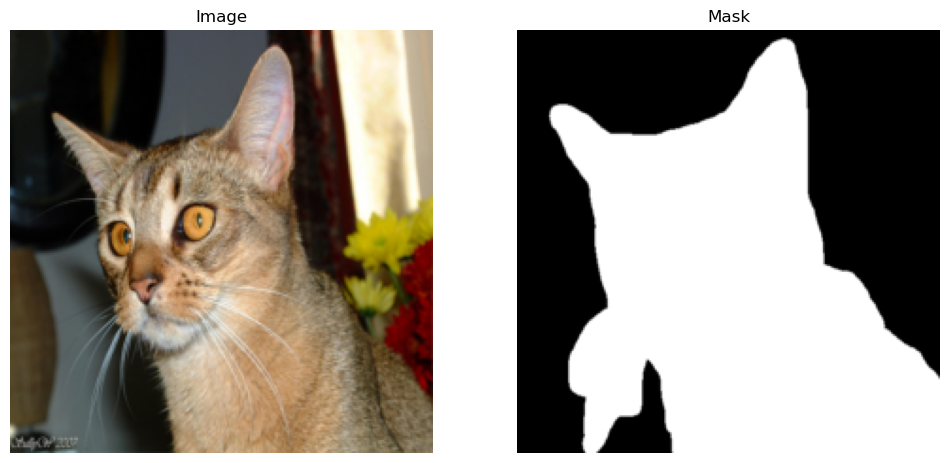

In [3]:
# Inspect dataset
image, mask = dataset[10]

# Rearrange the dimensions
# from (channels, height, width) to (height, width, channels)
image_np = image.numpy().transpose(1, 2, 0)

# Normalize the image array to [0, 1] for visualization
# This reverses the normalization applied during the transform
image_np = (image_np * [0.5, 0.5, 0.5]) + [0.5, 0.5, 0.5]  
image_np = np.clip(image_np, 0, 1)  # clip to the range [0, 1] for valid image values

# Convert the mask tensor to a numpy array for visualization
# Since the mask is a single-channel image, we use squeeze to remove the channel dimension for plotting
mask_np = mask.numpy().squeeze()

# Visualize the image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title('Image')
plt.axis('off')

# Visualize the mask
plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.show()


In [4]:
class FeatureToSegmentation(nn.Module):
    def __init__(self, feature_dim=2048, num_classes=1, image_height=224, image_width=224):
        super(FeatureToSegmentation, self).__init__()
        self.fc1 = nn.Linear(feature_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes * image_height * image_width)
        self.num_classes = num_classes
        self.image_height = image_height
        self.image_width = image_width

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        # Reshape to [N, C, H, W] for segmentation
        x = x.view(-1, self.num_classes, self.image_height, self.image_width)
        return x
    


In [5]:
class FeatureToSegmentationConv(nn.Module):
    def __init__(self, feature_dim=2048, num_classes=1):  # For binary segmentation
        super(FeatureToSegmentationConv, self).__init__()
        self.conv1 = nn.Conv2d(feature_dim, 512, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(512, num_classes, kernel_size=1)  # Final layer to num_classes
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        # Optionally add an upsampling step if needed
        # x = F.interpolate(x, size=(desired_height, desired_width), mode='bilinear', align_corners=False)
        return x

In [19]:
# Load backbone
    
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")) 

from torchvision.models import resnet50

# Load the pre-trained SimCLR backbone
backbone = resnet50(pretrained=False)
backbone.fc = nn.Identity()  # Remove the final fully connected layer

# Load the pre-trained weights
backbone.load_state_dict(torch.load("simclr_backbone.ckpt", map_location=torch.device(device)), strict=False)

# Remove avgpool and fc
backbone = nn.Sequential(*(list(backbone.children())[:-2]))

for param in backbone.parameters():
    param.requires_grad = False


/Users/chenkangan/tensorflow-test/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/chenkangan/tensorflow-test/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
class CombinedModel(nn.Module):
    def __init__(self, backbone, segmentation_head):
        super(CombinedModel, self).__init__()
        self.backbone = backbone
        self.segmentation_head = segmentation_head
        
    def forward(self, x):
        with torch.no_grad():  # Do not compute gradients for the backbone
            features = self.backbone(x)
        features = torch.flatten(features, start_dim=1)  # Flatten the features
        segmentation_output = self.segmentation_head(features)
        return segmentation_output
    
# Initialize the segmentation head
segmentation_head = FeatureToSegmentation() #FeatureToSegmentationConv() #

# Combine the backbone and the segmentation model
combined_model = CombinedModel(backbone, segmentation_head)
            

In [9]:
test_img, test_mask = next(iter(test_loader))

test_img.shape

torch.Size([32, 3, 224, 224])

In [77]:
dummy_input = torch.randn(1, 3, 224, 224)  # Example input tensor
features = backbone(dummy_input.to(device))
print(features.shape)  # Should print something like torch.Size([1, 2048, H, W])


torch.Size([1, 2048, 7, 7])


In [20]:
backbone(image.reshape(-1, 3, 224, 224)).shape

torch.Size([1, 2048, 7, 7])

In [18]:
backbone(image.reshape(-1, 3, 224, 224).to(device)).shape

torch.Size([1, 2048])

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import resnet50

class SegmentationHead(nn.Module):
    def __init__(self, in_channels=2048, out_channels=1, feature_size=(224, 224)):
        super(SegmentationHead, self).__init__()
        # Assuming we want to output a single-channel binary segmentation map
        self.upsample = nn.Upsample(size=feature_size, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(in_channels, 512, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(512, out_channels, kernel_size=1)
    
    def forward(self, x):
        x = self.upsample(x)
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        # No activation here, assuming the use of BCEWithLogitsLoss which combines sigmoid
        return x


class ResNetSegmentation(nn.Module):
    def __init__(self, backbone, segmentation_head):
        super(ResNetSegmentation, self).__init__()
        self.backbone = backbone
        self.segmentation_head = segmentation_head

    def forward(self, x):
        # Pass input through ResNet backbone
        features = self.backbone(x)
        # Pass backbone features through segmentation head
        segmentation_output = self.segmentation_head(features)
        return segmentation_output


device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")) 

# Initialize ResNet backbone
backbone = resnet50(pretrained=False)

# Load the pre-trained weights
backbone.load_state_dict(torch.load("simclr_backbone.ckpt", map_location=torch.device(device)), strict=False)

# Remove avgpool and fc, try the below code to see the original architecture
# print(list(backbone.children()))
backbone = nn.Sequential(*(list(backbone.children())[:-2]))

for param in backbone.parameters():
    param.requires_grad = False

# Initialize segmentation head
segmentation_head = SegmentationHead(in_channels=2048, out_channels=1, feature_size=(224, 224))

# Combine into a full model
model = ResNetSegmentation(backbone=backbone, segmentation_head=segmentation_head)


In [8]:
def train_segmentation_model(model, dataloader, num_epochs=10, learning_rate=1e-4, device='cpu'):
    # Set the model to training mode and move it to the specified device
    model.train()
    model.to(device)
    
    # Define the optimizer - only parameters with requires_grad=True will be updated
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    
    # Define the loss function
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        running_loss_batch = 0.0
        running_loss = 0.0

        for i, (images, masks) in enumerate(dataloader):
            images = images.to(device)

            # Ensure masks are LongTensor and on the correct device
            masks = masks.float().to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, masks)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Compute loss per every batch and cummulative loss
            running_loss_batch += loss.item()
            running_loss += loss.item()
                
            if (i+1) % 100 == 0 :    # Print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss_batch / 100))
                running_loss_batch = 0
                
        train_loss = running_loss / (len(dataloader) * dataloader.batch_size) # Total loss / total number of training data
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss}')
    
# Example usage of the train_segmentation_model function

# Call the training function
train_segmentation_model(model, train_loader, num_epochs=1, learning_rate=1e-4, device=device)


KeyboardInterrupt: 

In [ ]:
# Test performance
inspect_num = 10

img, mask = test_img[inspect_num].to(device), test_mask[inspect_num].to(device)

pred_mask = combined_model(img.reshape(-1, 3, 224, 224))

# Convert predictions to probability using sigmoid
pred_prob = torch.sigmoid(pred_mask)
# Convert probabilities to binary mask (e.g., threshold at 0.5)
pred_binary_mask = (pred_prob > 0.5).float()

# Move tensors to CPU for plotting
img_cpu = img.squeeze().cpu().detach()
mask_cpu = mask.squeeze().cpu().detach()
pred_binary_mask_cpu = pred_binary_mask.squeeze().cpu().detach()

# Normalize img for displaying purposes
img_display = img_cpu.permute(1, 2, 0)
img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())

# Plotting
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_display)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_cpu, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred_binary_mask_cpu, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()